In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from functions import *
import os
import math
import tensorflow_addons as tfa

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16520291753425472423
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5752881152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17461040208439811733
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [153]:
#CONFIG
crops = 3
rots = 4
split = 0.97
BATCH_SIZE = 4
#config aftertrain
thresh = 0.26

In [5]:
showing = True

In [6]:
imgs = tf.data.Dataset.list_files('training/images/*')

In [7]:
train_size = int(len(imgs)*split)
train_ds = imgs.take(train_size)
test_ds = imgs.skip(train_size)

In [8]:
for file in imgs.take(2):
    print(file.numpy())

b'training\\images\\satImage_069.png'
b'training\\images\\satImage_026.png'


In [9]:
def process_image(file_path):
    img = tf.io.read_file(file_path) # load the raw data from the file as a string
    img = tf.io.decode_image(img)/255
    
    parts = tf.strings.split(file_path, os.path.sep)
    tr = tf.constant('groundtruth')
    path = tf.strings.join((parts[0], tr, parts[2]), separator='\\')
    gt = tf.io.read_file(path) # load the raw data from the file as a string
    gt = tf.io.decode_image(gt)/255
    
    img1 = tf.image.rot90(img, k=0, name=None)
    gt1 = tf.image.rot90(gt, k=0, name=None)
    img2 = tfa.image.rotate(img, math.radians(45), interpolation='BILINEAR')
    gt2 = tfa.image.rotate(gt, math.radians(45), interpolation='BILINEAR')

    dataset = tf.data.Dataset.from_tensors((img1, gt1))
    dataset = dataset.concatenate(tf.data.Dataset.from_tensors((img2, gt2)))
    
    for k in range(1,rots):
        img3 = tf.image.rot90(img, k=k, name=None)
        gt3 = tf.image.rot90(gt, k=k, name=None)
        img4 = tfa.image.rotate(img3, math.radians(45), interpolation='BILINEAR')
        gt4 = tfa.image.rotate(gt3, math.radians(45), interpolation='BILINEAR')

        dataset = dataset.concatenate(tf.data.Dataset.from_tensors((img3, gt3)))
        dataset = dataset.concatenate(tf.data.Dataset.from_tensors((img4, gt4)))
    return dataset

In [10]:
def crop(img, gt):
    ite = math.floor(96/crops)
    
    seed=(int(np.random.rand(1)[0]*10000000),int(np.random.rand(1)[0]*10000000))
    base_img = tf.image.stateless_random_crop(img, (304,304,3), seed)
    base_gt = tf.image.stateless_random_crop(gt, (304,304,1), seed)
    dataset = tf.data.Dataset.from_tensors((base_img, base_gt))
    
    for i in range(0, 96, ite):
        for j in range(0, 96, ite):
            img1 = tf.image.crop_to_bounding_box(img, i, j, 304, 304)
            gt1 = tf.image.crop_to_bounding_box(gt, i, j, 304, 304)
            img2 = tf.image.flip_left_right(img1)
            gt2 = tf.image.flip_left_right(gt1)

            dataset = dataset.concatenate(tf.data.Dataset.from_tensors((img1, gt1)))
            dataset = dataset.concatenate(tf.data.Dataset.from_tensors((img2, gt2)))
    return dataset

In [11]:
train_ds = train_ds.flat_map(process_image)
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.cache()
train_ds = train_ds.flat_map(crop)
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.flat_map(process_image)
test_ds = test_ds.flat_map(crop)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

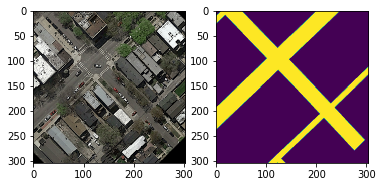

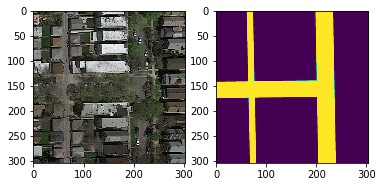

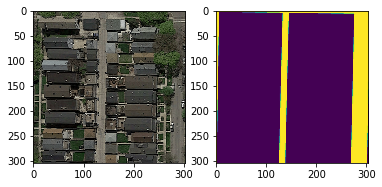

In [12]:
if showing:
    for image, gt in train_ds.shuffle(100).take(3):
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy()[0], interpolation='nearest')
        plt.subplot(1, 2, 2)
        plt.imshow(gt.numpy()[0], interpolation='nearest')
        plt.show()

In [13]:
train_ds

<PrefetchDataset shapes: ((None, 304, 304, None), (None, 304, 304, None)), types: (tf.float32, tf.float32)>

In [14]:
#Build the model
inputs = tf.keras.layers.Input((304, 304, 3))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(0.2), kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(0.2), kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(0.1), kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 304, 304, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 304, 304, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_coef_loss,
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])


history = model.fit(train_ds, batch_size=4, epochs=100, callbacks=[callback])
model.evaluate(test_ds)

Epoch 1/100
3686/3686 [==============================] - 197s 46ms/step - loss: 0.0443 - precision: 0.8991 - recall: 0.4139482 - prec - 168s 46ms/step - loss: 0.0480  - 169s 46ms/step - loss: 0.0477 - precision: 0.8895 - re - 183s 46ms/step - loss: 0 - 191s 46ms/step - 
Epoch 2/100
3686/3686 [==============================] - 185s 47ms/step - loss: 0.0207 - precision: 0.9470 - recall: 0.6971
Epoch 3/100
3686/3686 [==============================] - 183s 47ms/step - loss: 0.0162 - precision: 0.9617 - recall: 0.7370
Epoch 4/100
3686/3686 [==============================] - 186s 47ms/step - loss: 0.0136 - precision: 0.9698 - recall: 0.7596
Epoch 5/100
3686/3686 [==============================] - 183s 47ms/step - loss: 0.0117 - precision: 0.9747 - recall: 0.7750
Epoch 6/100
3686/3686 [==============================] - 184s 47ms/step - loss: 0.0103 - precision: 0.9783 - recall: 0.7863
Epoch 7/100
3686/3686 [==============================] - 184s 47ms/step - loss: 0.0091 - precision: 0.9812 - 

[0.004272881895303726, 0.9883176684379578, 0.8821101784706116]

In [154]:
import glob
import numpy as np
from PIL import Image
import re
test_images = glob.glob('test_set_images/*')
test_images = sorted_alphanumeric(test_images)

In [155]:
np_test_imgs = to_numpy(test_images, 304, 304)
np_test_imgs.shape

(200, 304, 304, 3)

In [156]:
np_test_imgs = np_test_imgs.astype(np.float32)/256

In [157]:
pr = model.predict(np_test_imgs)

In [158]:
def outputx16(nump, treshhold):
    pred = []
    for h in range(0,nump.shape[1],16):
        for w in range(0,nump.shape[0],16):
            if nump[w:w+16,h:h+16,:].sum()/238 > treshhold:
                pred.append(1)
            else:
                pred.append(0)
    return np.asarray(pred)

In [159]:
test_pred = model.predict(test_ds)

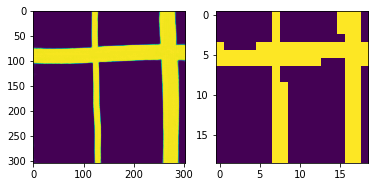

In [160]:
plt.subplot(1, 2, 1)
plt.imshow(test_pred[0], interpolation='nearest')
plt.subplot(1, 2, 2)
c = np.reshape(outputx16(test_pred[0], thresh),(19,19)).T
plt.imshow(c, interpolation='nearest')
plt.show()

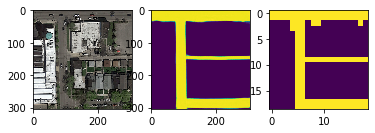

In [161]:
plt.subplot(1, 3, 1)
plt.imshow(np_test_imgs[5], interpolation='nearest')
plt.subplot(1, 3, 2)
plt.imshow(pr[5], interpolation='nearest')
plt.subplot(1, 3, 3)
c = np.reshape(outputx16(pr[5], thresh),(19,19)).T
plt.imshow(c, interpolation='nearest')
plt.show()

In [162]:
sized_pr = []
for i in range(0,int(len(pr)),4):
    a = np.concatenate((pr[i],pr[i+1]),axis=1)
    b = np.concatenate((pr[i+2],pr[i+3]),axis=1)
    sized_pr.append(np.concatenate((a,b),axis=0))
sized_pr = np.asarray(sized_pr)
sized_pr.shape

(50, 608, 608, 1)

In [163]:
np_test_imgs.shape

(200, 304, 304, 3)

In [164]:
sized_img = []
for i in range(0,int(len(np_test_imgs)),4):
    a = np.concatenate((np_test_imgs[i],np_test_imgs[i+1]),axis=1)
    b = np.concatenate((np_test_imgs[i+2],np_test_imgs[i+3]),axis=1)
    sized_img.append(np.concatenate((a,b),axis=0))
sized_img = np.asarray(sized_img)
sized_img.shape

(50, 608, 608, 3)

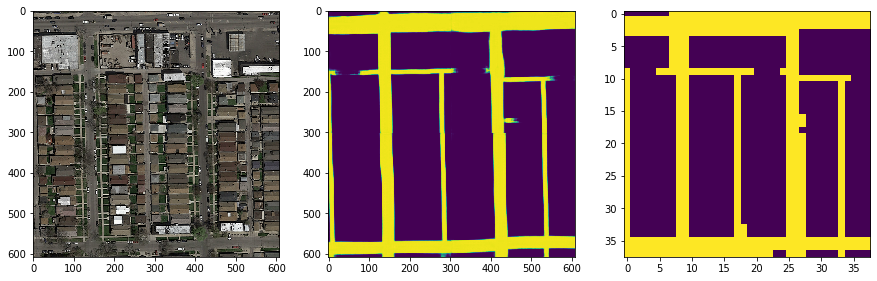

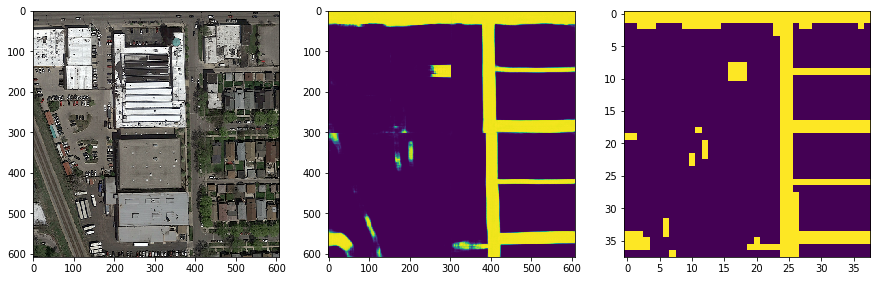

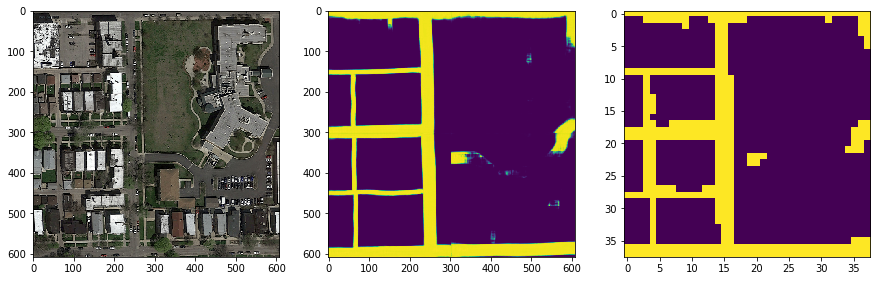

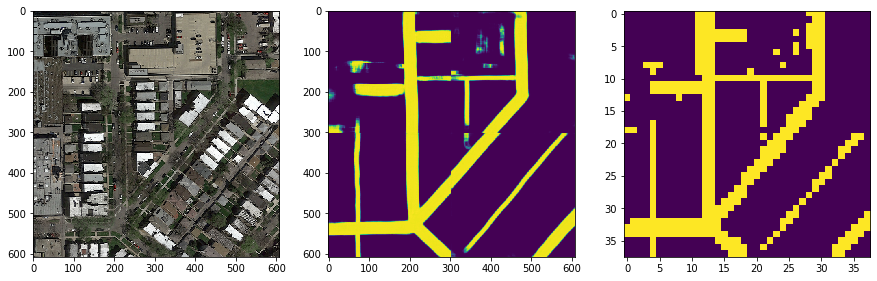

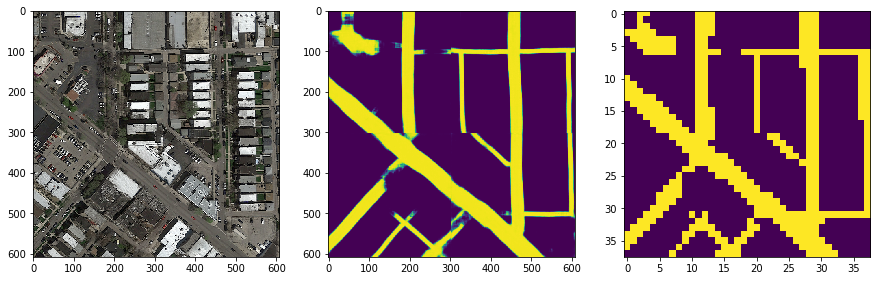

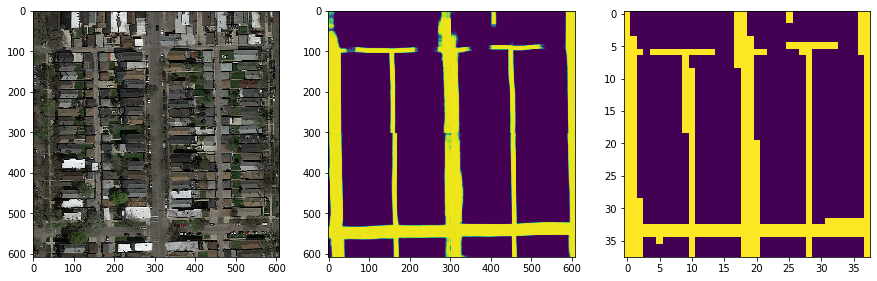

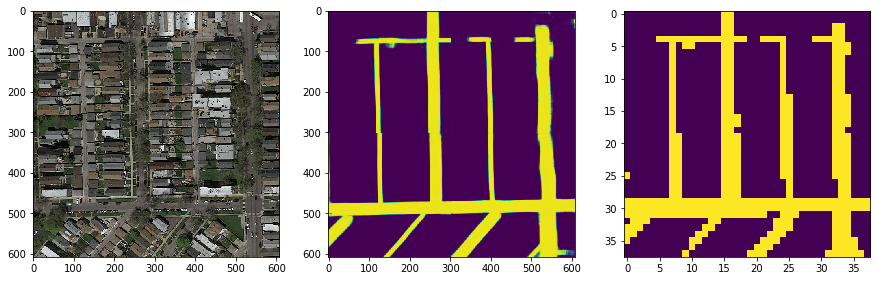

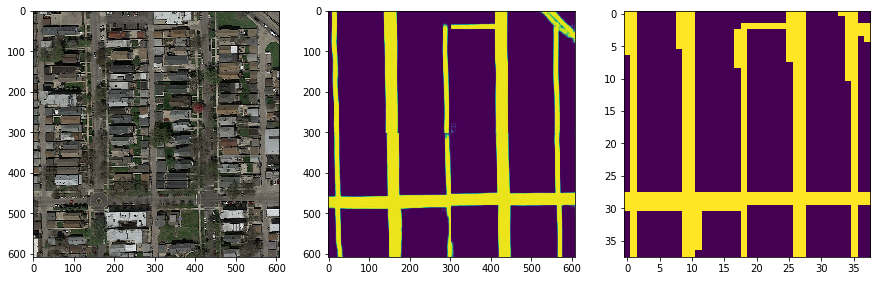

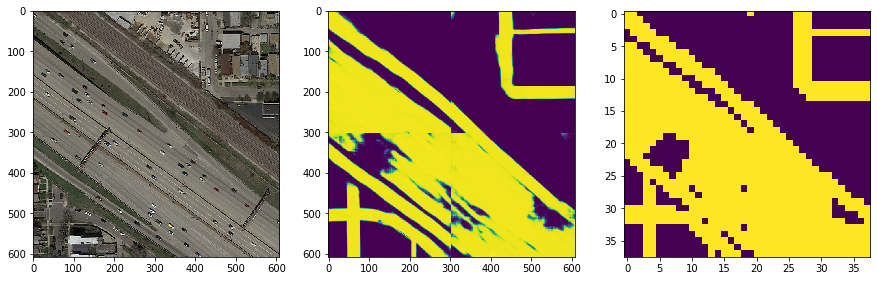

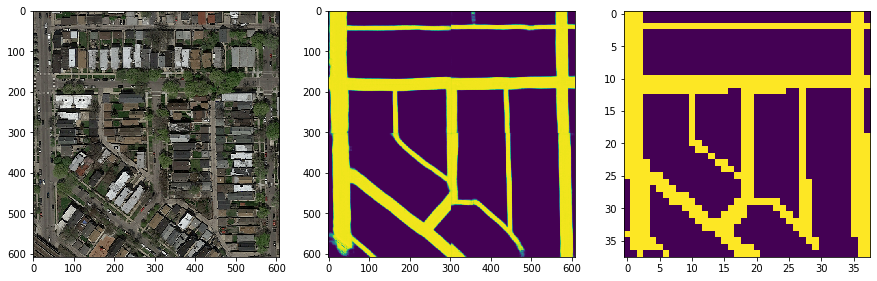

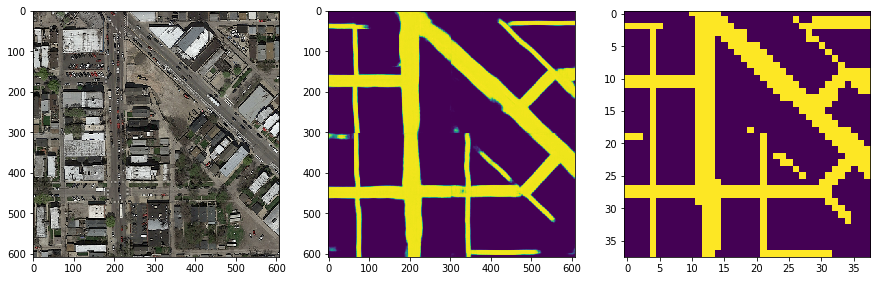

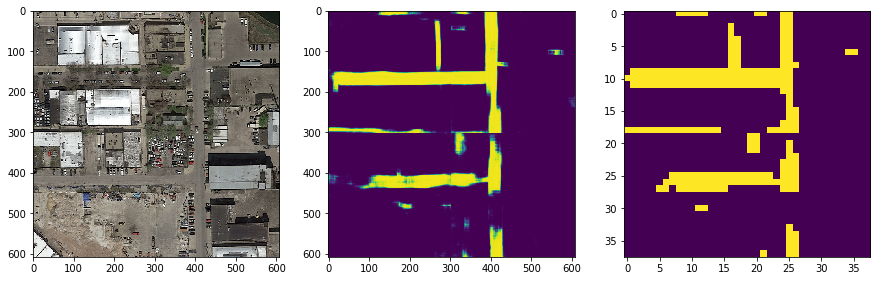

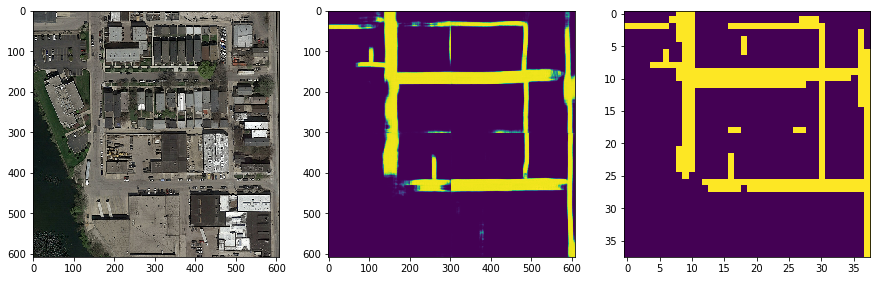

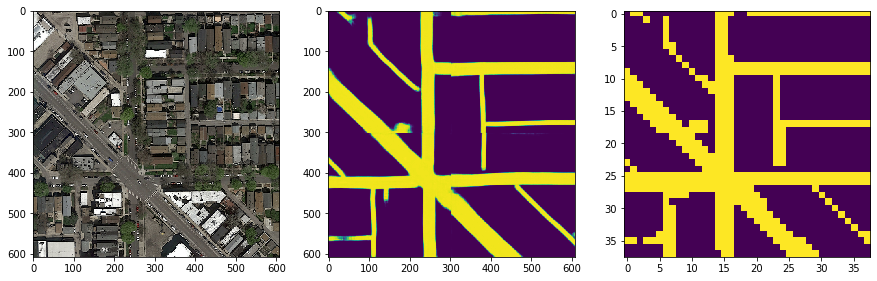

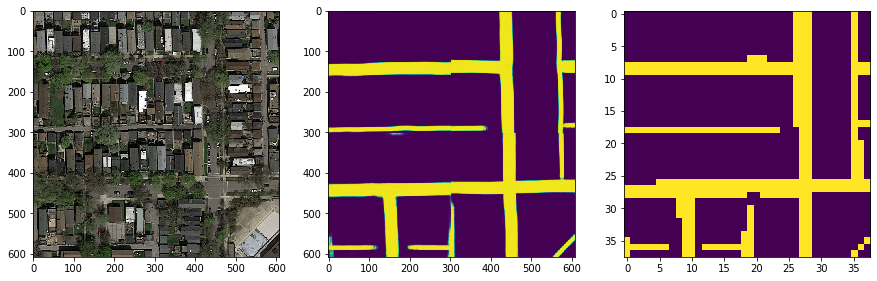

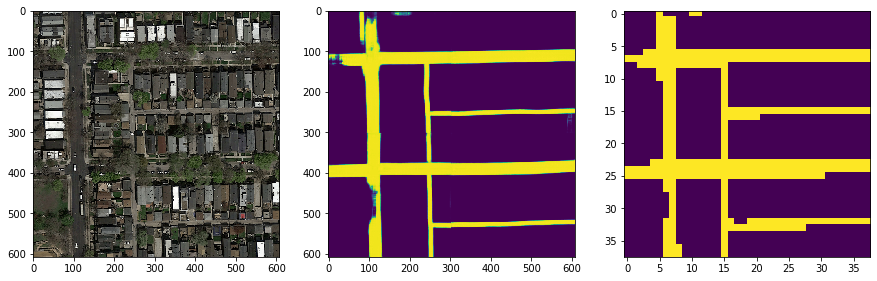

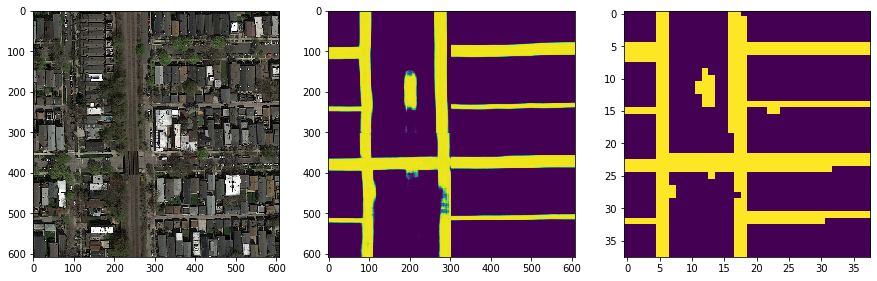

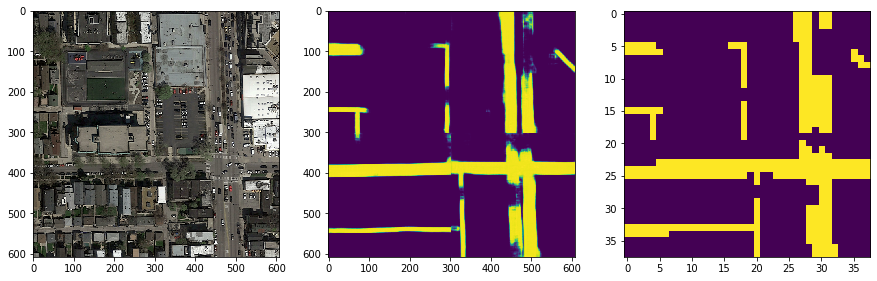

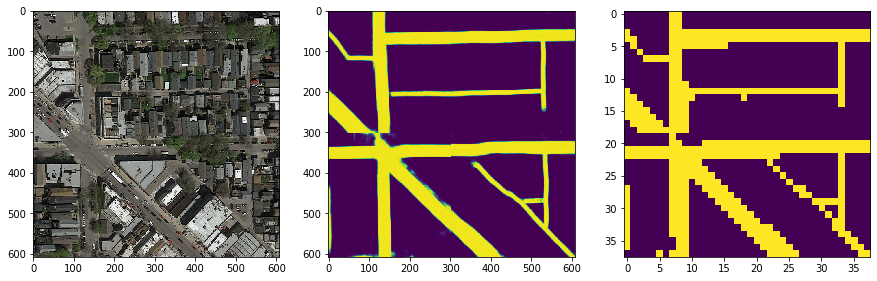

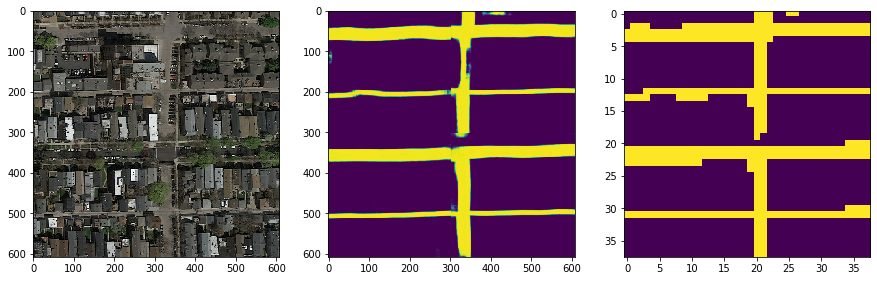

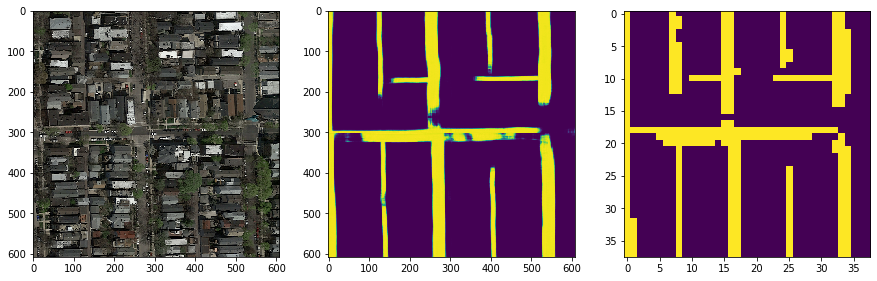

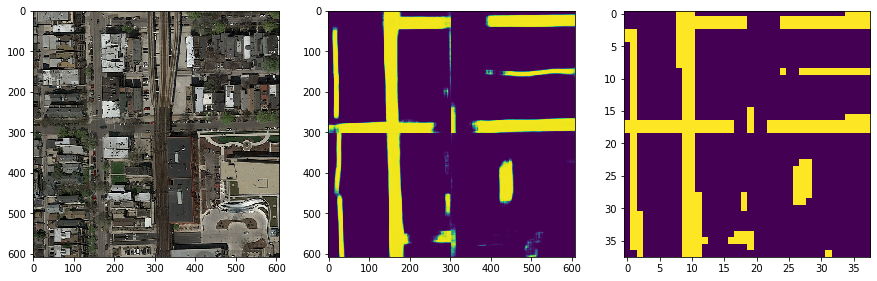

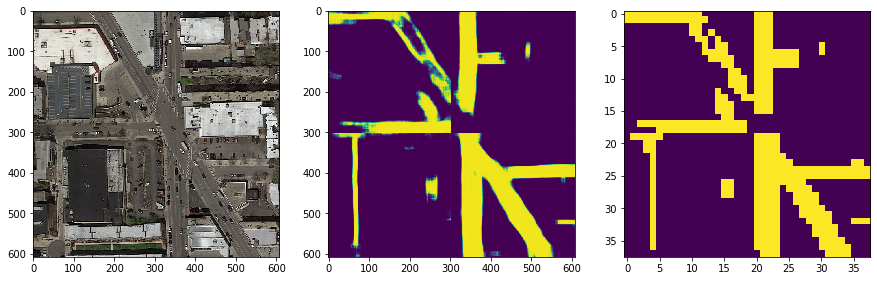

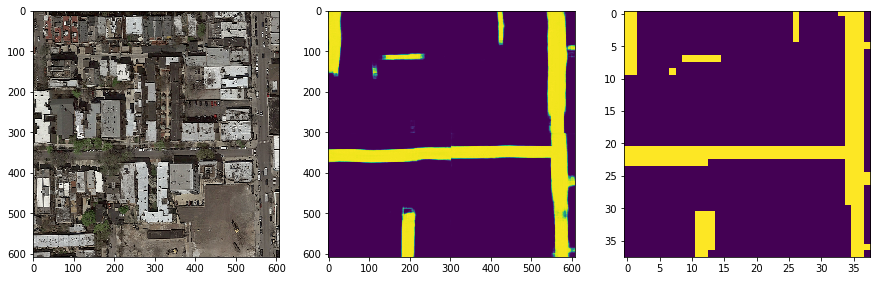

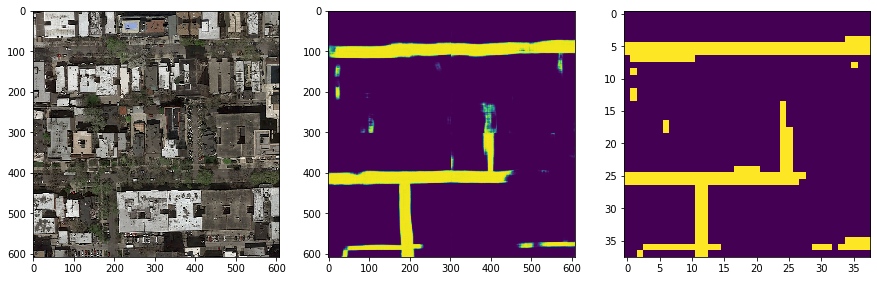

In [ ]:
for i in range(50):
    f, axs = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.imshow(sized_img[i], interpolation='nearest')
    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(sized_pr[i],(608,608)), interpolation='nearest')
    plt.subplot(1, 3, 3)
    c = np.reshape(outputx16(sized_pr[i], thresh),(38,38)).T
    plt.imshow(c, interpolation='nearest')
    plt.show()

In [ ]:
pred_first = outputx16(sized_pr[2],thresh)
print(pred_first.shape)
pred_first = np.reshape(pred_first, (38, 38))
print(pred_first.shape)

In [ ]:
print(sized_pr[0].shape)
a = outputx16(sized_pr[0], thresh)
print(a.shape)

In [ ]:
for i in range(1, len(sized_pr)):
    b = outputx16(sized_pr[i], thresh)
    a = np.concatenate((a,b),axis=0)

In [ ]:
ids = []
for i in range(1,51):
    for j in range(0,593, 16):
        for k in range(0,593, 16):
            ids.append('{:03}_{}_{}'.format(i,j,k))
ids = np.array(ids)
ids.shape

In [ ]:
a.shape

In [ ]:
a = a.astype(str)
a

In [ ]:
dirr = 'submissions/sub.csv'

f = open(dirr, "w")
f.write('id,prediction\n')

for i in range(a.shape[0]):
    f.write(ids[i] + ',' + a[i] + '\n')
f.close()

In [ ]:
from submission_to_mask import mask

mask(dirr)